<font color='green'>
    
# SkillFactory PROJECT. 
</font> 

### У онлайн школы есть идея организовать допродажу курсов в корзине для увеличения среднего чека, для этого нужна  рекомендательная система по курсам. 

<font color='green'>
    
##  Задача проекта:   
</font> 

### Построить рекомендательную систему, благодаря которой можно будет предлагать клиентам интересные им курсы.

<font color='green'>
    
##  Ход выполнения проекта:   
</font> 

> #### 1. Проанализировать исходные данные о продажах курсов
> #### 2. Составить таблицу популярности различных сочетаний курсов
> #### 3. На основе анализа подготовить систему принятия решения о рекомендации
> #### 4. Составить итоговую таблицу, в которой каждому ID курса будут рекомендоваться ещё два

<div class="alert alert-block alert-info">
<b>Исследуемый период 2017- 2018 годы</b></div>

<div class="alert alert-block alert-info">
<b>Сколько клиентов покупали курсы?</b></div>
<div class="alert alert-block alert-success">
<pre>
select  
    count(distinct c.user_id)
from 
    final.carts c join final.cart_items сi on c.id=сi.cart_id
where 
    c.state='successful' and сi.resource_type='Course'
</pre>    
<b>Ответ:</b> 49006
</div>

<div class="alert alert-block alert-info">
<b>Сколько всего есть различных курсов в онлайн школе?</b></div>
<div class="alert alert-block alert-success">
<pre>
select 
    count(distinct ci.resource_id)
from 
    final.cart_items ci
where 
    ci.resource_type='Course'
</pre>    
<b>Ответ:</b> 127
</div>

<div class="alert alert-block alert-info">
<b> Каково среднее число купленных курсов на одного клиента?</b></div>
<div class="alert alert-block alert-success">
<pre>
select
    round(count(ci.resource_id)*1.0/count(distinct c.user_id), 2)
from
    final.carts c join final.cart_items ci 
        on c.id=ci.cart_id
where c.state='successful' and ci.resource_type='Course'
</pre>    
<b>Ответ:</b> 1.44
</div>

<div class="alert alert-block alert-info">
<b> Сколько клиентов купили больше одного курса?</b></div>
<div class="alert alert-block alert-success">
<pre>
with purchases as 
(
    select  c.user_id, ci.resource_id
    from
    final.carts c join final.cart_items ci 
        on c.id=ci.cart_id
    where c.state='successful' and ci.resource_type='Course'
    group by 1,2
 ),


course_counter as 
(
    select p.user_id as user_id, count(distinct p.resource_id) as counts
    from purchases p
    group by 1 
)

select count(cc.user_id) 
from course_counter cc
where cc.counts>1
</pre>    
<b>Ответ:</b> 12656
</div>

Для дальнейшего анализа загрузим необходимые библиотеки 

In [54]:
import pandas as pd
import numpy as np
import itertools 
import collections
import seaborn as sns
import matplotlib.pyplot as plt
# import statistics
import psycopg2
import psycopg2.extras

Создадим функцию **getData()**, в которой выполним SQL-запрос. Затем с помощью этой функции получим датафрейм **data**, с информацией по всем продажам курсов в разрезе пользователей, купивших более одного курса.

In [55]:
def getData():
    query = '''with purchases as 
(
    select distinct c.user_id, ci.resource_id   --таблица с id пользователей и id  купленных ими курсов
    from
    final.carts c join final.cart_items ci 
        on c.id=ci.cart_id
    where c.state='successful' and ci.resource_type='Course'
    group by 1,2                                -- исключаем повторные покупки курсов
   
 ),


course_counter as                              -- id пользователя и количество покупок курсов
(
    select p.user_id user_id, count(distinct p.resource_id) counts
    from purchases p
    group by 1 
)

    select p.user_id, p.resource_id as course_id --id пользователя, совершившего больше 1 покупки, и id курса
    from purchases p 
    where p.user_id in
        (
        select user_id
        from course_counter
        where counts>1
        )

    '''.format()
    conn = psycopg2.connect(dbname='skillfactory', 
                            user='skillfactory', 
                            host='84.201.134.129',
                            password='cCkxxLVrDE8EbvjueeMedPKt',
                            port=5432)
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

data = pd.DataFrame(getData())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34074 entries, 0 to 34073
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    34074 non-null  int64
 1   course_id  34074 non-null  int64
dtypes: int64(2)
memory usage: 532.5 KB


In [56]:
data

,user_id,course_id
0,169821,679
1,1141426,504
2,1221330,566
3,1137633,571
4,645784,503
...,...,...
34069,1008455,794
34070,192823,516
34071,180357,551
34072,201631,570


Преобразуем датафрейм таким образом, чтобы каждому пользователю соответствовал список купленных им курсов

In [57]:
df=data.sort_values(['course_id']).groupby('user_id').course_id.apply(list).reset_index()
df

,user_id,course_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"
...,...,...
12651,2179430,"[566, 750]"
12652,2186581,"[794, 864, 1129]"
12653,2187601,"[356, 553, 571, 765, 912]"
12654,2188926,"[515, 743]"


Создадим список пар курсов **course_pairs_list**. Для покупателей, купивших больше 2 курсов, составим все возможные парные сочетания курсов

In [58]:
course_pairs_list=[]
for course in df['course_id']:
    for pair in itertools.combinations(course,2):
        course_pairs_list.append(pair)
len(course_pairs_list)

40017

In [59]:
new_list=set(course_pairs_list)
len(new_list)


3989

Получилось 40017 пар курсов, из них уникальных - 3989.  
Определим самую популярную пару курсов

In [60]:
rating=collections.Counter()
for pair in course_pairs_list:
    rating[pair]+=1
rating.most_common(1)

[((551, 566), 797)]

Самая популярная пара - курсы с номерами 551 и 566, такая покупка встречается у 797 покупателей

Создадим датафрейм с парами курсов и количеством покупок каждой пары **df1**

In [61]:
df1=pd.DataFrame(rating.most_common(), columns=['Pairs', 'Rating'])
df1.head()

,Pairs,Rating
0,"(551, 566)",797
1,"(515, 551)",417
2,"(489, 551)",311
3,"(523, 551)",304
4,"(566, 794)",290


In [62]:
df1.Rating.sum()

40017

Теперь разобъём пары на отдельные курсы, колонки **First** и **Second**, и отсортируем в порядке возрастания номера первого курса

In [63]:
df1['First']=df1['Pairs'].apply(lambda x: x[0])
df1['Second']=df1['Pairs'].apply(lambda x: x[1])
df1=df1.reindex(columns=['First', 'Second', 'Rating'])
df1.sort_values(by=['First','Second']).reset_index(drop=True)

,First,Second,Rating
0,356,357,100
1,356,360,1
2,356,361,17
3,356,366,15
4,356,367,12
...,...,...,...
3984,1185,1188,10
3985,1186,1187,4
3986,1186,1198,1
3987,1186,1201,1


In [64]:
f=df1.First.nunique()
s=df1.Second.nunique()
print(f'В первой колонке {f} уникальных курсов, а во второй {s} курса')

В первой колонке 117 уникальных курсов, а во второй 123 курса


но у нас есть данные о продаже 126 различных курсов, поэтому модифицируем датафрейм **df1** в **df3** таким образом, чтобы в колонке **First** была информация обо всех 126 курсах 

In [65]:
df2=df1.rename(columns={'First':'Second', 'Second':'First'})
df3=df1.append(df2).sort_values(['First', 'Second']).reset_index(drop=True)
df3

,First,Second,Rating
0,356,357,100
1,356,360,1
2,356,361,17
3,356,366,15
4,356,367,12
...,...,...,...
7973,1200,1104,1
7974,1201,571,1
7975,1201,1125,1
7976,1201,1144,1


Создадим список курсов **courses**

In [66]:
courses=df3['First'].unique()
len(courses)

126

Теперь для каждого курса из списка подберём 2 рекомендации - курсы, которые чаще всего покупают в паре с этим курсом. Результат сохраним в датафрейм **R**. 

In [67]:
Res=[]
for course in courses:
    
    top=df3[df3.First==course].sort_values(['Rating'], ascending=False).head(2) # две верхние позиции 
                                                                                # в списке частоты покупки пар курсов
    Recommendation_1=top.Second.iloc[0] # первая рекомендация
    
    Rating_1=top.Rating.iloc[0] # частота покупок этой пары курсов
    
    Recommendation_2=top.Second.iloc[1] # вторая рекомендация
    
    Rating_2=top.Rating.iloc[1] # рейтинг второй пары курсов
    
    Total=df3[df3.First==course].Rating.sum() # собственный рейтинг курса, к которому идут рекомендации
    
    Res.append((course, Recommendation_1, Rating_1, Recommendation_2, Rating_2, Total))

R=pd.DataFrame(Res,columns=['Course','Recommendation_1', 'Rating_1', 'Recommendation_2', 'Rating_2', 'Total'])
R

,Course,Recommendation_1,Rating_1,Recommendation_2,Rating_2,Total
0,356,571,103,357,100,763
1,357,571,112,356,100,770
2,358,570,25,752,19,174
3,359,570,16,358,15,156
4,360,745,17,516,12,106
...,...,...,...,...,...,...
121,1188,1141,15,513,11,95
122,1198,571,5,551,3,28
123,1199,523,2,359,1,8
124,1200,794,1,866,1,3


In [68]:
R.sort_values(['Total'], ascending=True).head(10)

,Course,Recommendation_1,Rating_1,Recommendation_2,Rating_2,Total
124,1200,794,1,866,1,3
125,1201,571,1,1125,1,4
85,902,503,1,519,1,4
123,1199,523,2,359,1,8
74,833,507,2,570,2,9
89,911,514,2,566,1,14
77,836,742,3,1141,3,17
73,830,566,3,814,3,17
75,834,566,3,809,1,19
116,1182,366,1,517,1,20


В полученной таблице есть курсы с небольшим количеством покупок, поэтому их нельзя с уверенностью рекомендовать потенциальным клиентам. Для того, чтобы определиться какое количество покупок можно считать достаточным для рекомендации, посчитаем описательные статистики для колонки **Total**.

In [69]:
R['Total'].describe()

count     126.000000
mean      635.190476
std       868.819785
min         3.000000
25%       154.500000
50%       348.000000
75%       758.750000
max      6074.000000
Name: Total, dtype: float64

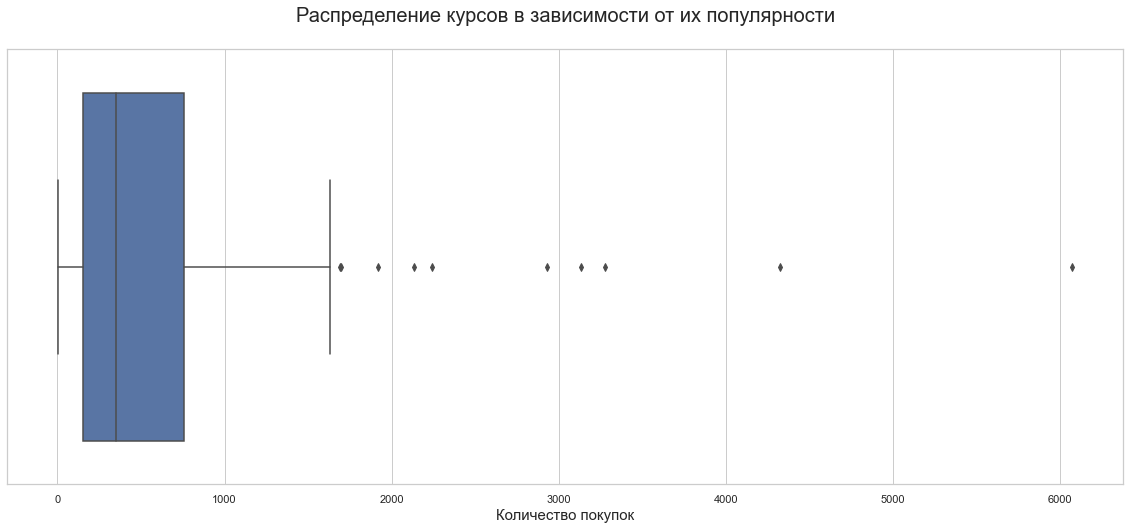

In [70]:
sns.set_theme(style="whitegrid")
boxplot=sns.boxplot(x=R.Total)
boxplot.set_title("Распределение курсов в зависимости от их популярности\n", size=20)
boxplot.set_xlabel("Количество покупок", fontsize=15)
fig = plt.gcf() #If no current figure exists, a new one is created using `~.pyplot.figure()`.
fig.set_size_inches(20, 8);

Медианное значение количества покупок курсов - 348 меньше среднего значения - 635,19. Данные распределены со смещением вправо.   
Выбросы на графике - это самые популярные курсы онлайн школы.

Задача проекта - увеличение среднего чека, поэтому необходимо выявить, какие курсы являются наиболее популярными, и сконцентрировать усилия на реализации именно этого ассортимента. Используем принцип Парето (20/80).

Определим 20% курсов с максимальным количеством рекомендаций **top_20** .  
Для этого посчитаем 80 персентиль и выберем топ курсы.


In [71]:
p=R.Total.quantile(0.8, interpolation='linear')
p

1046.0

In [72]:
# список топ курсов - 20% самых продаваемых
top_20=R[R.Total>=p].sort_values(['Total'], ascending=False).Course.tolist()
len(top_20)

26

Систему рекомендации построим следующим образом:  в рекомендациях для каждого курса хотя бы один должен быть из списка топ-20, а второй релевантным общей тематике.  

Если это условие не выполняется, то рекомендации  нужно заменить.

Первую рекомендацию **Recommendation_1**, как самую популярную из релеватных оставляем без изменения, а вторую **Recommendation_2** можно было бы заменить на самый популярный в этой же тематике из списка топ-20, но, к сожалению, в исходных данных нет информации о принадлежности каждого курса к той или иной линейке, поэтому заменим на самый популярный курс  - 551. 

Выделим список курсов, для которых нужна замена рекомендаций **short_list** и произведём замену.


In [73]:
short_list=R[(~R.Recommendation_1.isin(top_20))&(~R.Recommendation_2.isin(top_20))&(~R.Course.isin(top_20))].sort_values(['Total'], ascending=False).Course.tolist()
len(short_list)

19

In [74]:
R.loc[R.Course.isin(short_list), 'Recommendation_2']=551
R[R.Course.isin(short_list)]

,Course,Recommendation_1,Rating_1,Recommendation_2,Rating_2,Total
6,362,363,18,551,8,59
7,363,511,99,551,77,479
21,511,363,99,551,55,401
33,562,363,77,551,55,601
34,563,562,53,551,33,226
45,671,659,18,551,11,154
49,742,1141,34,551,22,239
70,813,672,18,551,7,148
77,836,742,3,551,3,17
81,863,908,10,551,8,171


Оставим в таблице только нужные колонки

In [75]:
R.drop(columns=['Rating_1', 'Rating_2', 'Total'], inplace=True)
R

,Course,Recommendation_1,Recommendation_2
0,356,571,357
1,357,571,356
2,358,570,752
3,359,570,358
4,360,745,516
...,...,...,...
121,1188,1141,551
122,1198,571,551
123,1199,523,359
124,1200,794,866


Получили итоговую таблицу с рекомендациями для 126 курсов онлайн школы, но всего представлено 127 курсов.

<div class="alert alert-block alert-info">
<b> Какой курс есть в линейке курсов, но продаж по нему ещё не было?</b></div>
<div class="alert alert-block alert-success">
<pre>
with c as
(
select distinct ci.resource_id
    from
    final.carts c join final.cart_items ci 
        on c.id=ci.cart_id
    where c.state='successful' and ci.resource_type='Course'
 )  

select  distinct ci.resource_id
    from
    final.cart_items ci left join c
        on c.resource_id=ci.resource_id
    where ci.resource_type='Course' and c.resource_id is null 
</pre>    
<b>Ответ:</b> 772
</div>

Добавим этот курс в таблицу и в качестве рекомендаций предложим самую популярную пару курсов.

In [76]:
R.loc[len(R)] = [772, 551, 566]
R

,Course,Recommendation_1,Recommendation_2
0,356,571,357
1,357,571,356
2,358,570,752
3,359,570,358
4,360,745,516
...,...,...,...
122,1198,571,551
123,1199,523,359
124,1200,794,866
125,1201,571,1125


In [77]:
R.sort_values(['Course'],inplace=True)
R.set_index('Course', inplace=True, drop=True)
R

,Recommendation_1,Recommendation_2
Course,,
356,571,357
357,571,356
358,570,752
359,570,358
360,745,516
...,...,...
1188,1141,551
1198,571,551
1199,523,359


Таблица готова. Выгрузим её в файл **course_recommendations.csv**

In [78]:
R.to_csv('course_recommendations.csv')

<font color='green'>
    
##  Задача проекта выполнена.  
</font> 